## Table of Contents

* データを知る
    * スキーマを理解する
    * 現象を理解する
    * 実際にデータを眺める
* python を使ったデータの理解
    * train / test の Report をさっくり作る
    * 学習用のデータと予測するデータの差分を知る
* モデリングのための特徴量作成
    * 連続変数の特徴量
    * テキストのシンプルな特徴量
    * カテゴリ変数の特徴量
        * CountEncoding
        * OneHotEncoding
        * より深く知る
* LightGBM でモデル作る
    * CrossValidation とは / なんで CrossValidation するの?
    * LightGBM でのモデリング・パラメータ
    * 特徴重要度 (FeatureImporatnce) の可視化
    * モデルを使って予測・submissionの作成

### Install Requirements

* pandas
* matplotlib
* seaborn
* scikit-learn
* pandas-profiling
* matplitlib-venn

In [1]:
!pip install -U \
    seaborn==0.11.1 \
    pandas==1.2.2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

In [3]:
INPUT_DIR = '/analysis/data/tutorial/inputs/'
OUTPUT_DIR = '/analysis/data/tutorial/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

In [4]:
train_df.head().T

,0,1,2,3,4
object_id,0011d6be41612ec9eae3,0012765f7a97ccc3e9e9,0017be8caa87206532cb,00181d86ff1a7b95864e,001c52ae28ec106d9cd5
art_series_id,93c092ba70beab248f31,95c14fb11c54281ad7e0,4c406890d208fe01f8fb,fa0891535500a4973db2,8065ed5063c5887e677d
title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen
description,NaN,NaN,"Portret van eenvrouw, zittend naast een tafel.","Een sint-bernardshond, staand in een landschap...",Woelige zee met zeilschepen.
long_title,"The Avenue of Birches, Jan Hackaert, 1660 - 1685","Struik in bloei, Richard Tepe (attributed to),...","Portret van een vrouw, Tresling & Comp., 1860 ...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...","Woelige zee met zeilschepen, anonymous, 1825 -..."
principal_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
principal_or_first_maker,Jan Hackaert,Richard Tepe,Tresling & Comp.,Bernard te Gempt,anonymous
sub_title,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,h 165mm × w 223mm,h 87mm × w 56mm,h 179cm × w 248cm × t 4cm,h 13cm × w 17.5cm × d 0.7cm
copyright_holder,NaN,erven Richard Tepe,NaN,NaN,NaN
more_title,The Avenue of Birches,Struik in bloei,Portret van een vrouw,A St Bernard Dog,Woelige zee met zeilschepen


## データを知る

まずはじめは、コードとかをかかずにわれわれは今どういうデータを取り扱っていて何を予測することが求められているのかについての理解を深めておきましょう。

### スキーマ(構造)を確認する

一番初めにやることは、コードを書くことではなくデータのスキーマと実際にどういうデータが入っているのかを確認することです。

自分が使える情報は何か・それはどのような構造を持っているか・実際にどういう値が入っているかをしっかりと把握してください。今回のデータは train / test 以外にも使えるテーブルがいくつか存在しています。データタブに各テーブルが持っている Field の情報が書かれていますので、ちゃんと読んでおきましょう。

### 実際に眺める

全体の構造がざっと理解できたら、次は**実際に**データをみましょう。この実際に見るというのは pandas で head を print とかではなくて、エクセルで開いて、フィルタなどを活用しながらデータを確認するようなちょっと泥臭い作業を指します。

この作業を経ることで、データに対する肌感を感じられます。例えば...

* Null がめっちゃ同時に起こっている → 特定の場合には2つの情報が同時に欠落するようなオペレーションになっているかも? というようなインサイト
* テキストのカラムでの表記ゆれ。人間が見たほうがすぐわかります。

今回使えるデータはどれも容量が小さいですからローカルでエクセルで開いてみて、ぱっぱっぱーっと見ていくだけでもだいぶ違うでしょう。このとき思ったこと・感じたことは, テーブルごとなどでどこかにメモしておくとあとあとで処理をするときに役に立って感動することがあります。

### 現象を理解する

次に「このデータはどういうふうに作られているか」について考えてみてください。特殊なデータを除いて、データとは何らかの行動のあしあとですから物理的・時間的な制約を多く受けます。あしあとに関して想像をふくらませることで Machine Learning のアルゴリズムに対してよりよい情報を作って渡すことができます。

例えば今回のデータの likes は人間の気持ちの現れです。
likes でソートして、多い方1000件と少ない方1000件を見比べてみて、自分だったらこの作品は良いねするかな? するならなぜか? など考えてみるなど、実際に良いねを押すひとの気持ちになって考えることは大事でしょう。

> #### 参考文献
* [教師データの作成方法について（誰がどこでいいねしているの？） | @nndropout1-san ](https://www.guruguru.science/competitions/16/discussions/7a4052f0-0ee9-4cf1-8d44-82997318b87e/)

### 予測対象を確認する

今回の予測対象は良いねの数です。

> like: 作品につけられたいいねの数。0以上の整数。この値が予測対象です。

良いね数というのはゼロ以上であることが確定していますから、ゼロ以下を予測することは意味がないことがわかります。参考文献にあるようにもっと likes について考えるのもとても良いと思います!

### 評価指標を確認する

コンペティションで利用される評価指標に関しての理解を深めておきましょう。今回の指標は RMSLE です。RMSLE を直接最適化する方法もありますが, 一度 log1p 変換をすると RMSE として取り扱えます (log1p変換後にRMSEとRMSLEは数学的に等価です)。一般的なアルゴリズムでは RMSE を扱うほうが得意ですから log1p 変換後の likes の値を予測して後で戻す方法が良さそうです。

## pythonを使ったデータの理解

データを知るの作業をある程度おこなえたら、次に python などプログラムを使って全体の傾向について見ていきます。

### train / test の Report をさっくり作る

傾向把握をいちいち記述しても良いですが煩雑です。pandas profiling というライブラリがあり、こちらを使うとデータフレームの統計量を一気に確認することが可能です。簡単な使い方は `ProfileReport` class に可視化したいデータフレームを渡して repot を作り `to_file` を呼び出して html ファイルとして保存する方法です。

保存した html をブラウザなどで開くと以下のような統計量をカラムごとに確認できてとても便利です。

* ユニークな値の数
* 頻度の高い値
* 意味の無いカラムや Null が多いカラムかどうか ...etc

In [5]:
report = ProfileReport(train_df)
report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

### 学習用のデータと予測するデータの差分を知る

> #### 参考文献
* [trainとtestでカテゴリー同士の被り具合を確認 | @Pirototo san](https://www.guruguru.science/competitions/16/discussions/dc8df46d-8519-468e-addb-b706431e47c7/)
* [Sweetviz train test | @sinchir0-san ](https://www.guruguru.science/competitions/16/discussions/451504f5-2448-4669-9acf-ffbaaca75ea2/)

学習データと予測データは(当たり前ですが)別のデータです。この別の度合いが強すぎる場合、特にカテゴリのカラムでテストデータ・学習データでかぶっていないものが多い場合には注意をする必要があります。(より一般的に言うとテストデータと学習データの分布が異なるもの一般が要注意な特徴量になります。)

分布が違いすぎるというのは即ち「学習していない状況で予測をする」ことです。
分布が違うと、学習データで見積もった予測性能とテストデータでの予測性能が乖離してしまう場合がありますので、そういったカラムを特徴量として使う場合には注意が必要です。

> 例: 浮世絵カテゴリについてとても予測できるモデルを作って、テストではすべて印象派の絵画が来たらそのモデルは予測性能が高いでしょうか?

## モデリングのための特徴量作成

## Pandas をつかう

以下は pandas をつかってデータ加工をしていきます! python になれることと pandas になれることとは若干の乖離がある部分がありますので、最初は大変だと思いますが notebook などで1行ずつ処理を追いかけて何が起こっているか判断するようにしていると上達は早いかなと思います。

In [6]:
series = train_df['dating_period']

### 値の変換

In [7]:
pd.Series([1, 1, 2]) ** 2

0    1
1    1
2    4
dtype: int64

In [8]:
pd.Series([1, 1, 2]) + pd.Series([1, 1, 2])

0    2
1    2
2    4
dtype: int64

In [9]:
def converter(x):
    if x < 10:
        return 1000
    return x

pd.Series([1, 100, 2]).map(converter)

0    1000
1     100
2    1000
dtype: int64

In [10]:
pd.Series([1, 1, 2]).map({1: 100})

0    100.0
1    100.0
2      NaN
dtype: float64

### 条件による絞り込み

In [11]:
# ある特定の条件で絞ったあたいだけ取り出したいときは, 一度変数に代入する方法がおすすめです。
idx = series == 19

In [12]:
series[idx]

1        19
2        19
3        19
4        19
5        19
         ..
12011    19
12012    19
12013    19
12018    19
12021    19
Name: dating_period, Length: 5042, dtype: int64

しぼり込み方法はいくつかあります. 代表的なものを下記に書いておきました。

In [13]:
series > 100 # 大小関係
series.isin([19, 20]) # 特定の集合にはいっているかどうか
series.isnull() # null かどうか
series.astype(str).str.contains('foo') # 文字列として評価した時に `contains` しているか

series == train_df['object_id'] # 他の column と値が一致しているか

0        False
1        False
2        False
3        False
4        False
         ...  
12021    False
12022    False
12023    False
12024    False
12025    False
Length: 12026, dtype: bool

複数条件の and / or をする場合には論理演算 `&` / `|` を使いましょう。このとき各条件を式として書く場合には `(` をいれるのを忘れないようにしてください。(論理演算のほうが `<` などの算術よりも先に評価されるためです)

In [14]:
# 18 以上かつ21以下
(series > 18) & (series <= 21)

0        False
1         True
2         True
3         True
4         True
         ...  
12021     True
12022    False
12023    False
12024    False
12025    False
Name: dating_period, Length: 12026, dtype: bool

特定条件のときだけ別の値で埋めたい時には `np.where` あるいは `pandas.Series.loc` で上書きする方法があります。

In [15]:
idx = series <= 18

# 18 以下は全部 None にする
np.where(idx, None, series)

array([None, 19, 19, ..., None, None, None], dtype=object)

### 集約関数

* aggregation の種類を一旦全部見ておく
    * groupby のあとに書く集約の方法のことを aggregation とよびます。
    * pandas に備わっている aggregation はかなり多くて便利なので有名ドコロだけでも全部さらっておくと自分で実装しなくて済むことが多いです。
    
  
* 基本的な算術:
    * sum
    * mean
    * median
    * std
    * var
* おぼえとくと役に立つ系
    * そのレコードまでの合計値: cumsum
    * ユニークな要素の数: nunique
    * 集合のおおきさ: size
    * その集合で最初とか最後の要素: first / last

In [16]:
group = train_df.groupby('principal_maker')

# 複数の絞り込みをする場合には array で指定します
train_df.groupby(['principal_maker', 'dating_sorting_date'])

In [17]:
group.size() # 著者が何回出てくるか. (value_counts と同じです)
group['sub_title'].nunique() # 著者ごとに何種類の sub_title を持っているか
group['dating_sorting_date'].agg(['min', 'max', 'mean']) # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)

,min,max,mean
principal_maker,,,
A. Böeseken,1858.0,1873.0,1865.800000
A. Cucumus & Cie.,1870.0,1870.0,1870.000000
A. Davanne & M. Aleo,1850.0,1850.0,1850.000000
A. Doyen,1840.0,1840.0,1840.000000
A. Fortier,1850.0,1850.0,1850.000000
...,...,...,...
weduwe Jacobus van Egmont,1724.0,1724.0,1724.000000
Édouard Denis Baldus,1855.0,1861.0,1857.750000
Émile Bernard,1897.0,1897.0,1897.000000


`pandas.concat` を `axis=1` (横方向) に行なうことで、複数の集約をまとめることができます。

In [18]:
agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique(), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df

,size,sub_title,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.800000
A. Cucumus & Cie.,1,1,1870.0,1870.0,1870.000000
A. Davanne & M. Aleo,1,1,1850.0,1850.0,1850.000000
A. Doyen,1,1,1840.0,1840.0,1840.000000
A. Fortier,1,1,1850.0,1850.0,1850.000000
...,...,...,...,...,...
weduwe Jacobus van Egmont,1,1,1724.0,1724.0,1724.000000
Édouard Denis Baldus,8,7,1855.0,1861.0,1857.750000
Émile Bernard,1,1,1897.0,1897.0,1897.000000


In [19]:
# 作者ごとに,それまでの年度の絵で獲得した合計のいいね数は?
sorted_group = train_df.sort_values('dating_year_late').groupby('principal_maker')
sorted_group['likes'].cumsum()

6191        41
3420       105
2769        76
6842       129
9506       102
         ...  
10463      552
10956    38478
11023       23
11764        7
12016       49
Name: likes, Length: 12026, dtype: int64

In [20]:
# Q1: タイトルごとの獲得良いね数の合計は?
# Q2: 年度と獲得手法ごとの作家のユニークな数は?
# Q3: 同一タイトル内で、もっとも獲得良いねが多い作家の名前は?
# Q4: 作者ごとの最高に良いねがもらえた作品名は?

### データ同士のマージ

基本的に left join だけわかっておけば大丈夫なことがおおいので left join を出来るようになりましょう。先ほどつくった集約情報を train_df の `"principal_maker"` 列へひも付け、をやってみます。

In [21]:
pd.merge(train_df['principal_maker'], 
         agg_df,
         on='principal_maker', 
         how='left')

,principal_maker,size,sub_title,min,max,mean
0,Jan Hackaert,3,3,1660.0,1660.0,1660.000000
1,Richard Tepe,180,149,1900.0,1920.0,1900.194444
2,Tresling & Comp.,1,1,1860.0,1860.0,1860.000000
3,Bernard te Gempt,1,1,1850.0,1850.0,1850.000000
4,anonymous,1692,1413,1250.0,1952.0,1783.027778
...,...,...,...,...,...,...
12021,Delboy & Baer,1,1,1900.0,1900.0,1900.000000
12022,Abraham Allard,13,13,1701.0,1703.0,1701.384615
12023,Noach van der Meer (II),2,2,1778.0,1787.0,1782.500000
12024,Romeyn de Hooghe,132,129,1655.0,1758.0,1682.318182


In [22]:
train_df.shape

(12026, 19)

left join をしているので `train_df` と同じ長さのデータフレームになっていることがわかります。


### 特徴量とは何か

予測変数に紐付いた説明変数のことを「特徴量」と呼びます。近年の進歩でたくさんのアルゴリズムが開発され予測能力は向上していますが、アルゴリズムに入力するデータは人間が用意しなくてはなりません。この予測の元になるデータを特徴量とよび、アルゴリズムが理解しやすい特徴量を作ることを特徴量エンジニアリングと呼びます。

基本的に特徴量は予測対象に対しての数値です。今回は特定の絵画 `object_id` に対して良いねを予測するので、特徴量も `object_id` に対して紐づくようなものを作る必要があります。

一番簡単なのは art_object table (train/test.csv) にある Column をそのまま使う方法です。これは明らかに 1-1 の関係ですね。

### 機械学習モデルが扱える形式に直す

機械学習が理解できるのは基本的に数値の形式のみです。テキストや画像などを取り扱う場合もありますが、それらもピクセルのRGBやNLPの手法により、最終的に数値化されて機械学習へとインプットされています。数値への変換は人間の仕事です。

### NumericなColumn

今回のデータで言うと数字なのは dating 系の値です。これらはそのまま使いましょう

In [23]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]
    
    return input_df[use_columns].copy()

In [24]:
create_numeric_feature(train_df)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0
2,19,1860.0,1880.0
3,19,1850.0,1879.0
4,19,1825.0,1874.0
...,...,...,...
12021,19,1900.0,1920.0
12022,18,1701.0,1714.0
12023,18,1778.0,1778.0
12024,17,1689.0,1690.0


### テキスト系のカラム

基本的にこうやってどんどんと特徴量と呼ばれるものを作っていきます。次はテキスト系を使ってみましょう。

テキストを最も簡単に数値にするには? そう長さを計れば良いのです。
pandas.Series には `str` という attribute があり、これを介することで文字列とした時の長さを計算できます。

In [25]:
train_df['title'].str.len()

0        21
1        15
2        21
3        16
4        27
         ..
12021    37
12022    60
12023    54
12024    29
12025    30
Name: title, Length: 12026, dtype: int64

In [26]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()
    
    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title'
        # and more
    ]
    
    for c in str_columns:
        out_df[c] = input_df[c].str.len()
        
    return out_df.add_prefix('StringLength__')

### カテゴリ系のカラム

文字列や数値だけれどユニークな数が少なくてカテゴリとみなせるものがあるでしょう。例えば性別カラムで中身が `"男"`, `"女"`, `"他"` と入っているような場合ですね。(これらに対して先ほどの文字列の長さを適用すると、すべて同じ値になってしまって予測の際に差分がなくて意味がないことに注意してください。)

カテゴリ系のカラムはいくつかの変換方法があります。ここでは王道として CountEncoding と OneHotEncoding を紹介します。

### CountEncoding

In [27]:
[1, 1, 1, 2]

[1, 1, 1, 2]

In [28]:
[3, 3, 3, 1]

[3, 3, 3, 1]

In [29]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'title',
        'principal_maker',
        # and more
    ]
    
    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)
    
    return out_df.add_prefix('CE_')

In [30]:
create_count_encoding_feature(train_df)

,CE_acquisition_method,CE_title,CE_principal_maker
0,4253.0,1,3
1,4253.0,1,180
2,1578.0,21,1
3,584.0,1,1
4,1157.0,1,1692
...,...,...,...
12021,3795.0,1,1
12022,4253.0,1,13
12023,3795.0,1,2
12024,4253.0,1,132


In [31]:
assert len(create_count_encoding_feature(train_df)) == len(train_df)
assert create_count_encoding_feature(train_df).equals(create_count_encoding_feature(train_df))

### OneHotEncoding

例えば `["a", "b", "a"]` という列を

```python
[
    [1, 0],
    [0, 1],
    [1, 0]
]
```

のように変換する操作を One-Hot-Encoding と言います。各行の第 `i` 番目の要素にその値が i 番目の要素と一致するかどうかの 0-1 の値が入ります。pandas でこれをやる場合には 

1. 一度 Series を Categorical に変換
2. pandas.get_dummies に渡す

という流れが簡単です。One Hot Encoding はカテゴリのユニーク数(カーディナリティとも言います)が多い時、列方向に巨大な sparse 行列になってしまうのが欠点です。濃度が大きい場合には Label Encoding など他の方法を試してみてください。

In [32]:
column = 'acquisition_method'

In [33]:
vc = train_df[column].value_counts()
categories = vc[vc > 20].index

In [34]:
categories

Index(['purchase', 'transfer', 'gift', 'unknown', 'bequest', 'loan',
       'nationalization 1795'],
      dtype='object')

In [35]:
# categories を明示的に指定することでカテゴリ数を固定できます
cat = pd.Categorical(train_df[column], categories=categories)

In [36]:
pd.get_dummies(cat)

,purchase,transfer,gift,unknown,bequest,loan,nationalization 1795
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
12021,0,1,0,0,0,0,0
12022,1,0,0,0,0,0,0
12023,0,1,0,0,0,0,0
12024,1,0,0,0,0,0,0


In [37]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'acquisition_method',
        'principal_maker'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:
        
        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = train_df[column].value_counts()
        vc = vc[vc > 20]
        
        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)
        
        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [38]:
create_one_hot_encoding(train_df.head(1)).head()

,acquisition_method=purchase,acquisition_method=transfer,acquisition_method=gift,acquisition_method=unknown,acquisition_method=bequest,acquisition_method=loan,acquisition_method=nationalization 1795,principal_maker=anonymous,principal_maker=Johann Sadeler (I),principal_maker=Bernard Picart,...,principal_maker=Rembrandt van Rijn,principal_maker=James Valentine,principal_maker=Jan Maurits Quinkhard,principal_maker=Adolphe Zimmermans,principal_maker=Wouter Johannes van Troostwijk,principal_maker=Cor Jaring,principal_maker=Jan Banning,principal_maker=Gerard Edelinck,principal_maker=Augusta Curiel,principal_maker=Jean Baptiste August Kessler
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


この他にも王道的なやり方としていくつかの特徴量への変換方法が存在しています。気になる方は Categorical Encoding などで調べてみると良いでしょう。

> #### 参考文献
* [lightGBM Baseline | @takoi san](https://www.guruguru.science/competitions/16/discussions/8d476062-3058-45a3-8a8c-d2d4973862b5/) では Label Encoding をつかった方法が紹介されています。

In [39]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [40]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """
    
    processors = [
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_one_hot_encoding
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [41]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 4/4 [00:00<00:00, 71.68it/s]

createcreate_numeric_feature  0.004[s]
createcreate_string_length_feature  0.061[s]
createcreate_count_encoding_feature  0.015[s]
createcreate_one_hot_encoding  0.010[s]
createcreate_numeric_feature  0.001[s]
createcreate_string_length_feature  0.025[s]
createcreate_count_encoding_feature  0.015[s]
createcreate_one_hot_encoding  0.010[s]


In [42]:
assert len(test_feat_df) == len(test_df)

## 学習を行なう

特徴量を作成できたので次にモデルの学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation とは

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

### なんで Cross Validation するの?

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

> 仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は `KFold` と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。(今回行なうのはこの方法です)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

あとは「各分割で特定のグループが重ならないようにする」Group K Fold もよく使われます。(よく見ると 0 ~ 4 で group の行の色が被らないようになっているのわかりますか?)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

その他にも時系列で区切る time split という方法もあります。どれを使えばよいかは test データがどのように構成されているか依存なので、つどつどデータを見て決定します。

### LightGBM による CrossValidation を用いた学習

今回は使う機械学習モデルとして lightGBM を使います。lightGBM は以下のような良い性質があります。

* 欠損値が存在している場合にも、欠損を埋めることなく自然に取り扱うことができる
* 特徴重要度をさっと出すことができる
* GBDT と呼ばれるアルゴリズムの一種で今回のタスクのようなテーブルデータで性能が高いことが知られている
* CPU 環境でも高速に学習・推論が行える

ほかにも理由はありますが u++ さんの [「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617) などが参考になります。

In [43]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。

In [44]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 
    
     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,
    
    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,
    
    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 
    
    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 
    
    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 
    
    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,
    
    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,
    
    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

### 予測対象の変換

RMSLE を擬似的に RMSE として扱うため `log1p` 変換を行います。

In [45]:
y = train_df['likes'].values
y = np.log1p(y)

In [46]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.21193
Early stopping, best iteration is:
[486]	valid_0's rmse: 1.21106
fit fold=0  0.350[s]
Fold 0 RMSLE: 1.2111
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.17842
Early stopping, best iteration is:
[456]	valid_0's rmse: 1.17561
fit fold=1  0.284[s]
Fold 1 RMSLE: 1.1756
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's rmse: 1.1853
fit fold=2  0.318[s]
Fold 2 RMSLE: 1.1853
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[318]	valid_0's rmse: 1.20698
fit fold=3  0.235[s]
Fold 3 RMSLE: 1.2070
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.18303
Early stopping, best iteration is:
[414]	valid_0's rmse: 1.18175
fit fold=4  0.272[s]
Fold 4 RMSLE: 1.1818
--------------------------------------------------
FINISHED | Whol

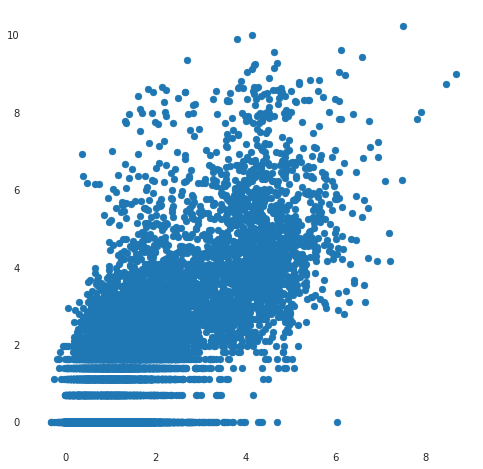

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oof, y)

### 特徴重要度の確認

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

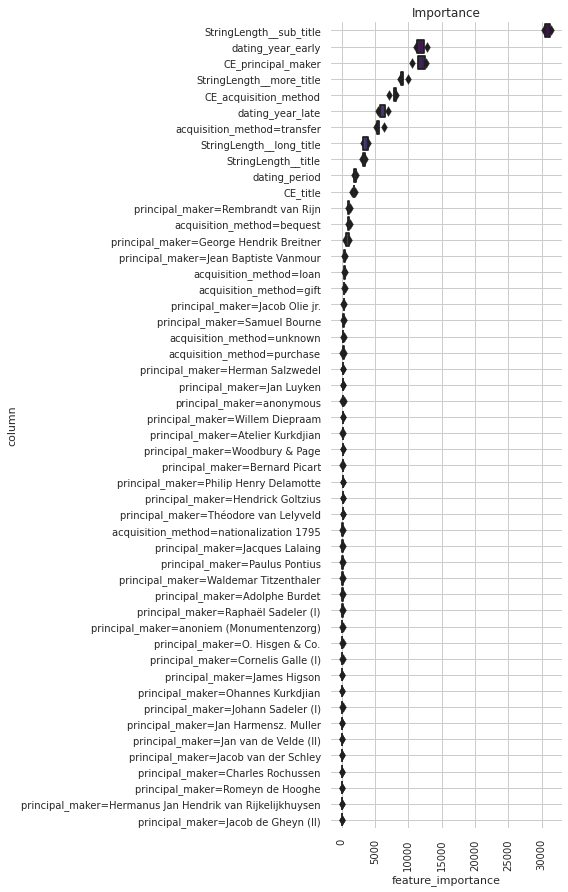

In [48]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

### 考察

* sub_title の文字列長が重要らしい。sub_title は絵画の大きさなどの属性が入ったカラムなので、大きい作品が like されやすい、などはありそう。
    * 実際にみて確かめる。
* 文字列カラムで言うと、more_title も重要。人気なものは美術館側も気合入れて説明を書いている可能性がある。
* たくさん登場する maker は重要。
    * 因果的には有名だからたくさん作品を所持しているのかも。
* 年度の重要性が高い。美術作品にも歴史と流れがあり、それを年度から汲み取っている可能性がある
    * 例えば日本では印象派がとても人気。印象派はあるブームをさすワードで 1850 ~ 1920 頃にしか存在しない。
    * 年度を数字とみなさずに、カテゴリに変換しても面白いかもしれない。
        * 例えば ~ 1700 / ~ 1800 / ~ 1900 ~  / それ以上 みたいな

In [49]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [50]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, '0001__submission.csv'), index=False)

* submission する前には予測値がまともかどうかちゃんと見ておきます。
    * あまりに大きくずれているときは実装がおかしい or 分布がずれている可能性が高いです。
    * 貴重なsubmissionを無駄にしないため一旦落ち着いて、チェックしましょう。ぐるぐるは逃げません。    
* 余裕があれば `sweetvis` などで学習と推論に使った特徴量も可視化すると良いです。あまりにずれている場合, 実装がおかしいかその特徴に関連する情報が train / test で大きく乖離している可能性があります。

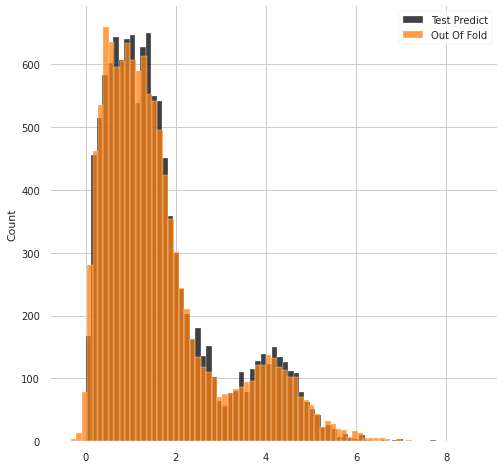

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

### Future Work

* データをより良く見て、性質を理解する (EDA)
* 特徴量をより凝ったものにする

これらは次回の講座で扱います!